# 👋 Hi there, hope you safe and well. This is for a general simulation procedure for any RCSB PDB structures containing ligand, with a special focous on small molecules. 

This notebook take http://zarbi.chem.yale.edu/ligpargen/namd_tutorial.html as a reference. This notebook is wrritten by quantaosun@gmail.com in Shanghai, China, 2021.


# The tutorial uses an example structure of T4 Lysozyme L99A with a Benzene molecule bound (PDB ID: 4W52.pdb)

**The overall procedure is as below**

0.   Install Anaconda
1.   Install pymol, vmd, and openmm, pdbfixer
2.   User input a PDB ID, pdbfixer fix and prepare it
3.   separate ligand and protein
4.   generate topology for ligand using LigParGen server
5.   combine psf and pdb of protein and ligand, vmd prepare NAMD input files.
6.   generate conf file for NAMD simulation. 
7.   use GPU accelerted NAMD simulate the job




# Now Switch to GPU

-------------------------------------------------------------------------
When you see a 👋 symbol, that is where you need to click the play button.
When you see a ⚠️ or ⚠️⚠️， that is where eithter need you to do some extra work or a reminder it is easy to go wrong.
-------------------------------------------------------------------------

---



In [ ]:
#@title 👋 1.Install Dependencies, this could take a while, be patient
!mkdir external-libraries
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /home/aistudio/external-libraries
#@title Install Pymol
! yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge vmd
#@title Install VMD

!yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge pymol-open-source
#install openmm
!yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge openmm
#install pdbfixer
!yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge pdbfixer
! /home/aistudio/external-libraries/bin/pip install py3Dmol
!yes | /home/aistudio/external-libraries/bin/conda install -c rdkit rdkit
#install csh shell for step 8 or step 9
!apt-get install csh
import sys
sys.path.append('/home/aistudio/external-libraries/lib/python3.7/')
import sys
sys.path.append('/home/aistudio/external-libraries/lib/python3.7/site-packages/')
#import rdkit for visualization purpose
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
from rdkit.Chem import MolFromPDBFile

In [ ]:

#@title 👋 2.Input a PDB id, with the .pdb. This will download and prepare this PDB complex.⚠️⚠️NOTE,make sure double check your structure after this step with any visualization software to see if there is a brolken backbone.
complex = "4W52.pdb" #@param {type:"string"}
!wget http://www.pdb.org/pdb/files/'{complex}'
!/home/aistudio/external-libraries/bin/pdbfixer  '{complex}' --ph=7  --replace-nonstandard --add-residues 

In [ ]:
#@title 👋 3.Spilit protien apart from ligand, input capital letters.
pdb_id = "4W52" #@param {type:"string"}
ligand_name = "BNZ" #@param {type:"string"}
#create ligand= resn H3E 
#create active_water= resn HOH within 5 of ligand
#remove resn HOH &! active_water
com_file = open('prepare.pml','w')
com_file.write('''
load 4W52.pdb
remove resn HOH
h_add elem O or elem N
select 4W52-BNZ, resn BNZ #Create a selection  from the ligand
select 4W52-receptor, 4W52 and not 4W52-BNZ #Select all that is not the ligand
save 4W52-BNZ.pdb, 4W52-BNZ
save 4W52-receptor.pdb, 4W52-receptor    
''')
com_file.close()
#!sed -i "s/4W52/$pdb_id/g" prepare.pml
#!sed -i "s/BNZ/$ligand_name/g" prepare.pml
#@title 3.Spilit complex to protein and ligand
%cd /content/
! /home/aistudio/external-libraries/bin/pymol -c prepare.pml
#for the sake of LigParGen, we need add H atom to ligand

# 👋 ⚠️4.Download ligand molecule and Uplaod ligand (Ligand should be added with H atoms before submitting.) to LigParGen and download the generated ZIP file.  Upload the *zip file contains all the parameter files here.
http://zarbi.chem.yale.edu/ligpargen/index.html 

In [ ]:
#@title 👋 ⚠️ 5. Combine and Manupilate Structures. remove any line with TER and the connectivity information. Moreover, change the residue number of Benzene ligand for continuity according to the last residue number of the protein, and add a ⚠ Chain name like ⚠️a capital B to the ligand if there is no one. then upload the complex_fixed.pdb here.
%%bash
unzip BNZ_6AA283.zip
cp tmp/*.pdb ./
cp tmp/*.prm ./
cp tmp/*.rtf ./
cat 4W52-receptor.pdb BNZ_6AA283.pdb > complex.pdb

In [ ]:
#@title 👋 ⚠️6. Download amino acid topology file and Setting up system with VMD，Upload ⚠️ionized.pdb and ionized.psf here after finishing all VMD steps. Skip next cell if you follow the instruction of image.
%cd /content/
!wget http://traken.chem.yale.edu/doc/top_opls_aam.inp
! echo "Please use your local VMD finish 1 to 10 according to the image below, the image is a screen shot from http://zarbi.chem.yale.edu/ligpargen/namd_tutorial.html "


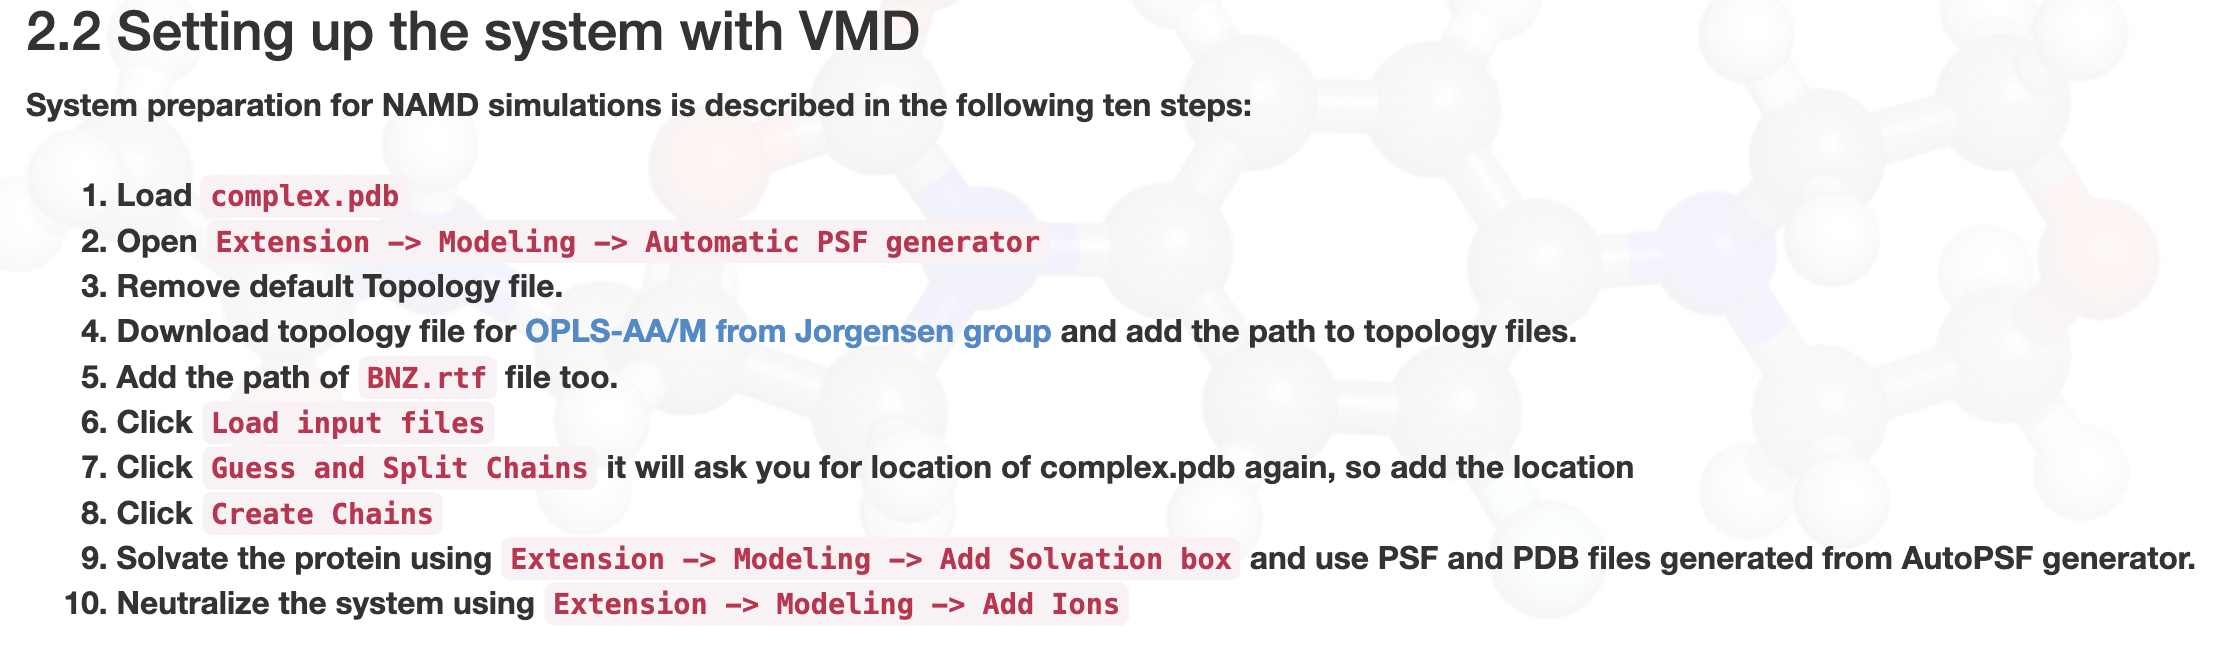

In [ ]:
#@title  👋 ⚠️6-2. Alternatively, you could run this cell to generate ionized.pdb and ionized.psf, provide the name of ligand RTF file.
RTF_name = "" #@param {type:"string"}
com_file = open('UNK.pgn','w')
com_file.write('''
package require psfgen   
topology top_opls_aam.inp
topology BNZ.rtf 

pdbalias HIS HSD
pdbalias atom SER HG HG1
pdbalias residue HIS HSE     
pdbalias atom ILE CD1 CD

segment A {pdb complex.pdb}  
coordpdb complex.pdb A   
guesscoord   
writepdb complex_autopsf.pdb     
writepsf complex_autopsf.psf 

package require solvate  
solvate complex_autopsf.psf complex_autopsf.pdb -t 5 -o complex_wb 
package require autoionize
autoionize -psf complex_wb.psf -pdb complex_wb.pdb -neutralize -o ionized
set ubq [atomselect top all]
measure minmax $ubq   ## USE THE DIFFERENCE BETWEEN MIN AND MAX FOR CELL BASIS VECTOR DIMENSION
measure center $ubq   ## USE THE CENTER FOR CELLBASIS ORIGIN
exit    
''')
com_file.close()
sed -i "s/BNZ/'{RTF_name}'/g" UNK.pgn
!/home/aistudio/external-libraries/bin/vmd -dispdev text -e UNK.pgn

⚠️7. Download and modify the NAMD conf files, change periodic vectors in minimisation and nvt conf. Change parameter file path and simulation steps if necessary


```
# ⚠️Use the command here to measure the water box size, then put the dimension vector to the PBC section of the conf files⚠️
set all [atomselect top all] 
set mm [measure minmax $all] # use the DIMENSION between MIN and MAX for CELL BASIS VECTOR DIMENSION
measure center $all # Use the CENTER for CELLBASIS ORIGIN

```



In [ ]:
#@title 👋 7.Download and modigy the NAMD configuration files, mount to Google Drive to copy your NAMD software here
NAMD_tarball_PATH = "/content/drive/MyDrive/softwares/NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA-SingleNode.tar.gz" #@param {type:"string"}
NAMD_version_NAME = "NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA" #@param {type:"string"}
from google.colab import drive
drive.mount('/content/drive')
!tar -xvf '{namd_gz_file_path}'
! /content/'{NAMD_folder_name}'/namd3 -h
#build a new folder to store all simulation stuff
!mkdir simulation
!cp ionized.* simulation
!cp *.rtf simulation
!cp *.inp simulation

In [ ]:
#@title 👋 8.Run the Simulation and Copy result back to Goolge Drive every 1 ns, by default this is a 10-ns simulation
Drive_path_you_want_to_store_result = "" #@param {type:"string"}
com_file = open('run.csh','w')
com_file.write('''
#!/bin/csh
#

# Generated by quantaosun@gmail.com based on CHARMM-GUI (http://www.charmm-gui.org) v3.5
#
# The following shell script assumes your NAMD executable is namd3 and that
# the NAMD inputs are located in the path defined by NAMD_verson_NAME variable.
#
# Only one processor is used below. To parallelize NAMD, use this scheme:
#     charmrun namd2 +p4 input_file.inp > output_file.out
# where the "4" in "+p4" is replaced with the actual number of processors you
# intend to use. In google colab, it is usually "2".

set equi_prefix = step4_equilibration
set prod_prefix = step5_production
set prod_step   = step5

# Running equilibration step
/content/'{NAMD_folder_name}'/namd3 +p2 ${equi_prefix}.inp > ${equi_prefix}.out

# Running production for 10 nanoseconds
set cnt    = 1
set cntmax = 10

while ( ${cnt} <= ${cntmax} )
    # create appropriate input file using ${prod_prefix}.inp as template
    if ( ${cnt} == 1 ) then
        set outputname = "${prod_step}_${cnt}"
        # change only the output name
        sed "s/${prod_prefix}/${outputname}/" ${prod_prefix}.inp > ${prod_step}_run.inp
    else
        @ cntprev = ${cnt} - 1
        set inputname  = "${prod_step}_${cntprev}"
        set outputname = "${prod_step}_${cnt}"
        # change input and output names from template file
        sed "s/${equi_prefix}/${inputname}/" ${prod_prefix}.inp | \
            sed "s/${prod_prefix}/${outputname}/" > ${prod_step}_run.inp
    endif

    # run the simulation for 1 nanosecond
   /content/'{NAMD_folder_name}'/namd3 +p2 ${prod_step}_run.inp > ${outputname}.out
    #copy the simulation result back to google drive every 1ns.
    cp -r simulation 12345678 
    @ cnt += 1
end
    
''')
com_file.close()
!mkdir simulation
%cd simulation
!sed -i "s/12345678/'{Drive_path_you_want_to_store_result}'/g" run.csh
!csh run.csh

# If your encounter some issue, please report it on github or write me an email quantaosun@gmail.com ヾ(￣▽￣)Bye~Bye~